In [1]:
import sys
sys.path.append('../../')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing
n_cores = multiprocessing.cpu_count()

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, IsolationForest, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression, GenericUnivariateSelect, f_regression
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import r2_score
from autofeat import FeatureSelector
import lightgbm as lgb

from aml_project.utils import load_df, results_to_csv

In [3]:
# Load data
#df_x_train, df_x_val, df_x_test, df_y_train, df_y_val = load_df('data', 0.2)
df_x_train, df_x_test, df_y_train = load_df('data', 0)
X_train = df_x_train.values
X_test = df_x_test.values
y_train = df_y_train.values.ravel()

Loaded data successfully:
 - X_train	(1212, 832)
 - X_test	(776, 832)
 - y_train	(1212, 1)


# Data exploration

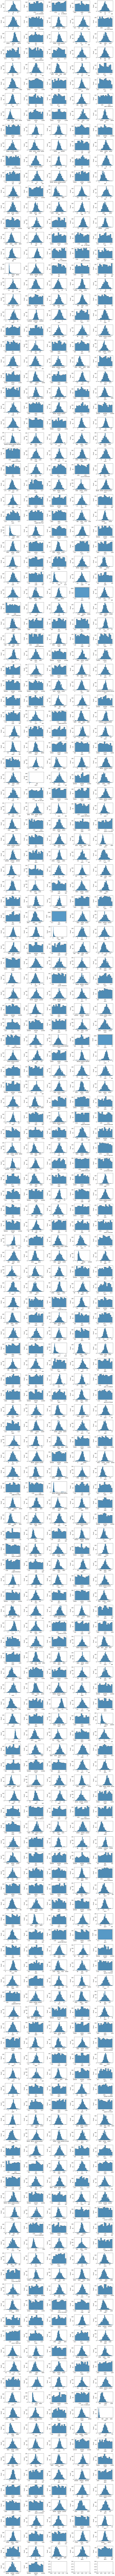

In [20]:
columns = df_x_train.columns
ncols = 5
nrows = len(columns) // ncols + 1
fig, axes = plt.subplots(figsize=(3*ncols, 2*nrows), nrows = nrows, ncols=ncols)
axes = axes.flatten()

for i, c in enumerate(columns):
    sns.histplot(df_x_train[c], ax=axes[i])
plt.tight_layout()

# Feature engineering

In [4]:
def scale_data(X_train, X_test, y_train, params={'method': 'standard'}):
    method = params.pop('method')
    if method == 'standard':
        scaler = StandardScaler(**params)
    elif method == 'robust':
        scaler = StandardScaler(**params)
    else:
        print(f'Scaler {method} not implemented')
    scaler.fit(X_train)    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train

def reload_data(X_train, X_test, y_train, params={'base_dir':'data', 'test_size':0.2}):
    df_X_train, df_X_test, df_y_train = load_df(*params)
    return df_X_train.values, df_X_test.values, df_y_train.values.ravel()

def remove_outliers(X_train, X_test, y_train, params={'reduction': 'union', 'methods':[('forest', {})]}):
    methods = params.pop('methods')
    reduction = params.pop('reduction')
    candidates = []
    for method, inner_params in methods:
        if method == 'forest':
            candidates.append(get_outliers_forest(X_train, y_train, params=inner_params))
        elif method == 'local':
            candidates.append(get_outliers_local(X_train, y_train, params=inner_params))
        else:
            print(f'Method {method} not implemented')
            return
        
    if reduction == 'union':
        outliers = list(set().union(*candidates))
    elif reduction == 'intersection':
        outliers = list(set().intersection(*candidates))
    else:
        print(f'Reduction {reduction} not implemented')
    inliers = np.ones(len(y_train), np.bool)
    inliers[outliers] = 0
    return X_train[inliers], X_test, y_train[inliers]

def get_outliers_local(X_train, y_train, params={}):
    outliers = LocalOutlierFactor(**params).fit_predict(X_train, y_train)
    mask = np.where(outliers < 0)[0]
    return mask

def get_outliers_forest(X_train, y_train, params={}):
    outliers = IsolationForest(**params).fit_predict(X_train, y_train)
    mask = np.where(outliers < 0)[0]
    return mask
        
def impute_data(X_train, X_test, y_train, params={'method': 'knn'}):
    method = params.pop('method')
    if method == 'knn':
        knn = KNNImputer(**params).fit(X_train, y_train)
        X_train_imputed = knn.transform(X_train)
        X_test_imputed = knn.transform(X_test)
        
    elif method in ['mean', 'median']:
        simple_imputer = SimpleImputer(strategy='mean', n_jobs=-1, **params).fit(X_train, y_train)
        X_train_imputed = simple_imputer.transform(X_train)
        X_test_imputed = simple_imputer.transforrm(X_test)
    else:
        print(f'Method {method} not implemented')
        return
        
    return X_train_imputed, X_test_imputed, y_train

def select_features_autofeat(X_train, X_test, y_train, params={}):
    fsel = FeatureSelector(n_jobs=-1, **params).fit(X_train, y_train)
    X_train_selected = fsel.transform(X_train)
    X_test_selected = fsel.transform(X_test)
    return X_train_selected, X_test_selected, y_train

def select_features(X_train, X_test, y_train, params={'reduction':'union', 'methods':[('mutual_info', {})]}):
    features_list = []
    reduction = params.pop('reduction')
    methods = params.pop('methods')
    for method, inner_params in methods:
        if method == 'corr':
            features_list.append(get_features_corr(X_train, y_train, **inner_params))
        elif method == 'mutual_info':
            features_list.append(get_features_mutual_info(X_train, y_train, **inner_params))
        elif method == 'f_regression':
            features_list.append(get_features_f_regression(X_train, y_train, **inner_params))
        elif method == 'random_forest':
            features_list.append(get_features_random_forest(X_train, y_train, **inner_params))
        else:
            print(f'Method {method} not implemented')
    
    if reduction == 'union':
        selected_features = list(set().union(*features_list))
    elif reduction == 'intersection':
        selected_features = list(set().intersection(*features_list))
    else:
        print(f'Reduction {reduction} not implemented')
        
    return X_train[:, selected_features], X_test[:, selected_features], y_train


def get_features_corr(X_train, y_train, k_best=50):
    corr = np.corrcoef(np.concatenate([X_train, y_train.reshape(-1, 1)], axis=1).T)
    selected_features = abs(corr[:-1, -1]).argsort()[-k_best:]
    return selected_features

def get_features_mutual_info(X_train, y_train, k_best=50):
    mutual_info = mutual_info_regression(X_train_imputed, y_train)
    selected_features_mutual = mutual_info.argsort()[-k_best:]
    return selected_features_mutual

def get_features_f_regression(X_train, y_train, k_best=50):
    return f_regression(X_train, y_train)[0].argsort()[-k_best:]

def get_features_random_forest(X_train, y_train, k_best=50, n_estimators=50):
    rfr = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)
    rfr.fit(X_train, y_train)
    return rfr.feature_importances_.argsort()[-k_best:]

def run_pipeline(steps, X_train, X_test, y_train):
    for step in steps:
        method, params = step
        X_train, X_test, y_train = method(X_train, X_test, y_train, params=params)
    return X_train, X_test, y_train

In [5]:
# with lgb -> 0.64 local, leaderboard priv. 0.7
steps = [
    (impute_data, {'method': 'knn', 'n_neighbors':3}),
    (scale_data, {'method': 'robust'}),
    (select_features, {'reduction': 'union', 'methods': [
        ('f_regression', {}),
        ('random_forest', {})
    ]}),
    (remove_outliers, {'reduction': 'union', 'methods':[
        ('local', {}),
        ('forest', {})
    ]})
]
X_train_pipe, X_test_pipe, y_train_pipe = run_pipeline(steps, X_train, X_test, y_train)

/Users/jodok/02 Code/spring21-JodokVieli/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [6]:
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
def custom_r2(preds, train_data):
    labels = train_data.get_label()
    return 'r2', r2_score(labels, preds), True

lgb_train = lgb.Dataset(X_train_pipe, y_train_pipe)
lgb.cv(lgb_params, lgb_train, nfold=10, feval=custom_r2, num_boost_round=300)

/Users/jodok/02 Code/spring21-JodokVieli/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

{'l2-mean': [83.00224509576746,
  79.04372042565261,
  75.7891290232146,
  72.70490570386,
  69.57035766825155,
  66.67154162128699,
  63.90624570871105,
  61.471795257504844,
  59.14531627421469,
  57.161513327832246,
  55.40307067928459,
  53.655292925972674,
  52.04343541927907,
  50.74426876449244,
  49.60346492484341,
  48.17342641888596,
  46.98746636227852,
  45.77963507108207,
  44.94450781885843,
  44.191178150326905,
  43.42645913619167,
  42.64583536015286,
  41.8861103203776,
  41.2026138069884,
  40.45386849048698,
  39.929587870531506,
  39.50060244827053,
  39.00769701776047,
  38.59357876983928,
  38.25744503272032,
  37.93492667392918,
  37.49998743249594,
  37.194810935029416,
  36.89001954638009,
  36.57181985518902,
  36.2834892887836,
  36.09346301710734,
  35.84501686426895,
  35.660066464221195,
  35.45111726363818,
  35.3015007189682,
  35.22393762370998,
  35.019660033658596,
  34.79042595807646,
  34.64036019550083,
  34.55514198286559,
  34.401490340693854,
 

In [7]:
gbm = lgb.train(lgb_params, lgb_train, num_boost_round=300)
y_pred = gbm.predict(X_test_pipe)
results_to_csv(y_pred, 'results.csv')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002956 seconds.
You can set `force_col_wise=true` to remove the overhead.
